In [390]:
import numpy as np
class HiddenMarkovModel():
    def __init__(self, hidden_dim, output_dim):
        self.H = hidden_dim
        self.D = output_dim
        self.initialize_params()
    def set_params(self, pi, A, B):
        assert((H,H)==A.shape)
        assert((H,D)==B.shape)
        assert((H,)==pi.shape)
        assert(np.std(np.sum(A,axis=1))<0.1)
        assert(np.std(np.sum(B,axis=1))<0.1)
        assert(np.abs(np.sum(pi)-1)<0.1)
        self.pi, self.A, self.B = pi, A, B
    def sample(self, T):
        pi, A, B = self.pi, self.A, self.B
        X = np.zeros(T, dtype=int)
        Z = np.zeros(T, dtype=int)
        for t in range(T):
            p = A[Z[t-1]] if t else self.pi
            Z[t] = np.random.choice(np.arange(self.H), p=p)
            X[t] = np.random.choice(np.arange(self.D), p=B[Z[t]])
        return X, Z
    def initialize_params(self):
        pi = np.random.rand(H)
        pi /= np.sum(pi)
        A = np.random.rand(H,H)
        A /= np.sum(A, axis=1, keepdims=True)
        B = np.random.rand(H,D)
        B /= np.sum(B, axis=1, keepdims=True)
        self.pi, self.A, self.B = pi, A, B
    def update(self, X):
        # initialize intermediate parameters
        N, T = X.shape
        pi, A, B = self.pi, self.A, self.B
        alpha = np.zeros((N,T,H))
        beta = np.zeros((N,T,H))
        c = np.zeros((N,T))
        
        # solve for alpha, beta, and c
        beta[:,T-1,:] = 1
        for t in range(T):
            alpha[:,t,:] = (B[:,X[:,t]].T)*(alpha[:,t-1,:]@A) if t else B[:,X[:,0]].T*pi
            c[:,t] = np.sum(alpha[:,t,:], axis=1)
            alpha[:,t,:] /= c[:,t].reshape(N,1)
        for t in reversed(range(T-1)):
            beta[:,t,:] = (B[:,X[:,t+1]].T*beta[:,t+1,:])@A.T/c[:,t+1].reshape(N,1)

        # solve for gamma and xi
        gamma = alpha*beta
        assert(np.std(np.sum(gamma, axis=2))<0.1)
        xi = np.zeros((N,T-1,H,H))
        for n in range(N):
            for t in range(T-1):
                xi[n,t] = np.outer(alpha[n,t],beta[n,t+1])
                xi[n,t] *= B[:,X[n,t+1]]*A/c[n,t+1]
        assert(np.std(np.sum(xi, axis=(2,3))) < 0.1)

        # update parameters pi, A, B
        pi = np.sum(gamma[:,0], axis=0)/np.sum(gamma[:,0])
        assert( np.abs(np.sum(pi)-1) < 0.1)
        A = np.sum(xi, axis=(0,1))
        A /= np.sum(A, axis=1)
        assert(np.abs(np.sum(A)-H) < 0.1)
        B *= 0
        for n in range(N):
            for t in range(T):
                B[:,X[n,t]] += gamma[n,t]
        B /= np.sum(B, axis=1, keepdims=True)
        
        # assign parameters pi, A, B to new values
        self.pi, self.A, self.B = pi, A, B
        
        # return likelihood
        return np.round(-np.sum(np.log(c))/N,3)
        
    def fit(self, X, num_iters=10):
        import time
        mlelist = []
        pilist, Alist, Blist = [self.pi], [self.A], [self.B]
        print("**","~"*20, " Beginning training ","~"*20, "**")
        for i in range(num_iters):
            start = time.time()
            mle = self.update(X)
            list(map(lambda x,y: x.append(y),
                     [pilist,Alist,Blist,mlelist],
                     [self.pi,self.A,self.B,mle]))
            print(f"Iteration {i}/{num_iters}:\tlog-likelihood={mle}\t{time.time()-start:.2f} sec/iter")
        history = {'pi':pilist, 'A':Alist, 'B':Blist,'mle':mlelist}
        print("**","~"*20, " Printing results ","~"*20, "**")
        print("**","~"*20, " Learned parameters ","~"*20, "**")
        print("pi_train:\n ", np.round(self.pi,2))
        print("A_train:\n", np.round(self.A,2))
        print("B_train:\n", np.round(self.B,2))
        return history
    def hidden_states(self, x):
        """print("For some reason, the output really give z[1:]
        of hidden states. Not sure why!!! """
        T = len(x)
        pi, A, B, H = self.pi, self.A, self.B, self.H
        delta = np.zeros((T,H))
        psi = np.zeros((T,H), dtype=int)
        delta[0] = np.log(pi*B[:,x[0]])
        for t in range(1,T):
            arg = np.log(A) + np.log(B[:,x[t]]).reshape(H,1)+delta[t-1]
            delta[t] = np.max(arg, axis=0)
            psi[t] = np.argmax(arg, axis=0)
        q = np.zeros(T, dtype=int)
        q[-1] = np.argmax(delta[-1])
        for t in reversed(range(1,T)):
            q[t-1] = psi[t, q[t]]
        return q

** ~~~~~~~~~~~~~~~~~~~~  Beginning training  ~~~~~~~~~~~~~~~~~~~~ **
Iteration 0/30:	log-likelihood=582.573	0.35 sec/iter
Iteration 1/30:	log-likelihood=423.032	0.34 sec/iter
Iteration 2/30:	log-likelihood=422.017	0.34 sec/iter
Iteration 3/30:	log-likelihood=420.569	0.34 sec/iter
Iteration 4/30:	log-likelihood=417.743	0.35 sec/iter
Iteration 5/30:	log-likelihood=411.315	0.35 sec/iter
Iteration 6/30:	log-likelihood=397.212	0.35 sec/iter
Iteration 7/30:	log-likelihood=377.04	0.34 sec/iter
Iteration 8/30:	log-likelihood=364.325	0.34 sec/iter
Iteration 9/30:	log-likelihood=360.417	0.34 sec/iter
Iteration 10/30:	log-likelihood=359.078	0.36 sec/iter
Iteration 11/30:	log-likelihood=358.483	0.35 sec/iter
Iteration 12/30:	log-likelihood=358.173	0.34 sec/iter
Iteration 13/30:	log-likelihood=357.982	0.36 sec/iter
Iteration 14/30:	log-likelihood=357.858	0.33 sec/iter
Iteration 15/30:	log-likelihood=357.775	0.35 sec/iter
Iteration 16/30:	log-likelihood=357.718	0.35 sec/iter
Iteration 17/30:	log-lik

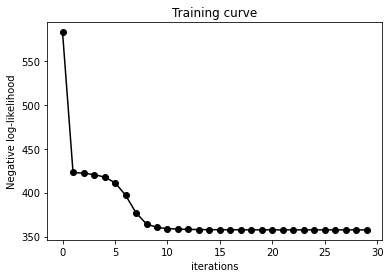

Prediction accuracy over 50 samples of length 500:
0.94


In [393]:
# np.random.seed(4)
# # create the true markov model, with true parameters
# H = 2
# D = 3
# pi = np.array([0.5,0.5])
# A = np.array([[0.9,0.1],[0.2,0.8]])
# B = np.array([[1/3,1/3,1/3],[1/10,1/10,4/5]])
# hmm_true = HiddenMarkovModel(H, D)
# hmm_true.set_params(pi, A, B)

# create the true markov model, with true parameters
H = 2
D = 3
pi = np.array([0.5,0.5])
A = np.array([[0.85,0.15],[0.2,0.8]])
B = np.array([[9/10,1/20,1/20],[1/20,1/20,9/10]])
hmm_true = HiddenMarkovModel(H, D)
hmm_true.set_params(pi, A, B)

# generate data: N trials of sequences of length T
N = 50
T = 500
X = np.empty((N,T), dtype=int)
Z = np.empty((N,T), dtype=int)
for n in range(N):
    X[n], Z[n] = hmm_true.sample(T)
    
# fit the true markov model
hmm = HiddenMarkovModel(H,D)
history = hmm.fit(X, num_iters=30)
print("**","~"*20, " True parameters ","~"*20, "**")
print("pi:\n ", np.round(pi,2))
print("A:\n", np.round(A,2))
print("B:\n", np.round(B,2))

# plot training curves
plt.plot(history['mle'], 'ko-')
plt.xlabel('iterations')
plt.ylabel('Negative log-likelihood')
plt.title('Training curve')
plt.show()

# show how well it predicts the hidden states
Z_pred = np.array([hmm.hidden_states(X[n])[:-1] for n in range(N)])
Z_true = Z[:,1:]
print(f"Prediction accuracy over {N} samples of length {T}:")
print(np.round(np.mean(Z_pred==Z_true),3))

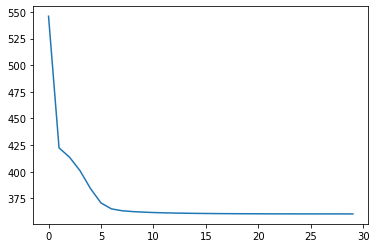

In [392]:
plt.plot(history['mle'])

$$ p(x_1,\ldots,x_t,z_t) = \alpha(z_t)$$
Therefore, since
$$ \alpha(z_t) = p(x_t|z_t)\sum_{z_{t-1}} p(z_t|z_{t-1})\alpha(z_{t-1}),$$
we can take the logs for numerical underflow, then determine the max likelihood for paths ending at each of the $H$ hidden states of $z_t$

In terms of matrices, this is 
$$ \alpha_h^{(t)} = B_{h,x^{(t)}}\odot(\alpha^{(t-1)}\cdot A) $$
taking logs
$$ \log\alpha_h^{(t)} = \log(B_{h,x^{(t)}}) + \log(\sum_{h'}\alpha_{h'}^{(t-1)}\cdot A_{h'h}) $$

We need to build a function $\psi(z_t)$ that returns the value of $z_{t-1}$ that gives the maximal value for the $k$th component of $z_k$. In other notation, find $\psi_k^{(t-1)}=\underset{k'}{\text{argmax }}p(z^{(t)}_k|z^{(t-1)}_{k'})$

This is done by modifying the above to
$$ \psi_k^{(t)} = \underset{k'}{\text{argmax }}\{ \log B_{k',x^{(t+1)}} + \log(\alpha_{k'}^{(t)}1_k)+\log(A_{k'k})\}$$

In [370]:
# create the true markov model, with true parameters
H = 2
D = 3
pi = np.array([0.5,0.5])
A = np.array([[0.85,0.15],[0.2,0.8]])
B = np.array([[9/10,1/20,1/20],[1/20,1/20,9/10]])
hmm_true = HiddenMarkovModel(H, D)
hmm_true.set_params(pi, A, B)

T = 150
x, z = hmm_true.sample(T)

In [371]:
hmm_true.hidden_states(x)[:-1]==z[1:]

For some reason, the output really give z[1:]
of hidden states. Not sure why


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [359]:
delta = np.zeros((T,H))
psi = np.zeros((T,H), dtype=int)
delta[0] = np.log(pi*B[:,x[0]])
for t in range(1,T):
    arg = np.log(A) + np.log(B[:,x[t]]).reshape(H,1)+delta[t-1]
    delta[t] = np.max(arg, axis=0)
    psi[t] = np.argmax(arg, axis=0)
q = np.zeros(T, dtype=int)
q[-1] = np.argmax(delta[-1])
for t in reversed(range(1,T)):
    q[t-1] = psi[t, q[t]]

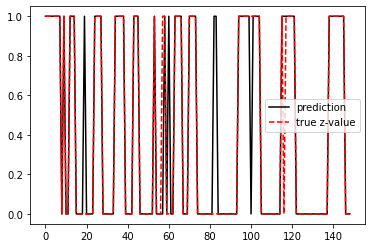

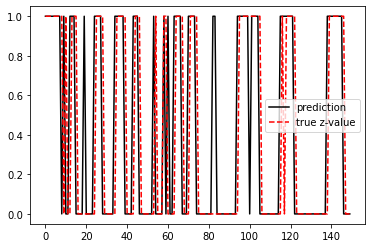

In [360]:
plt.plot(q[:-1], 'k-', label='prediction')
plt.plot(z[1:], 'r--', label='true z-value')
plt.legend()
plt.figure()
plt.plot(q, 'k-', label='prediction')
plt.plot(z, 'r--', label='true z-value')
plt.legend()

In [358]:
np.mean(q[:-1]==z[1:]), np.mean(q==z) 

(0.9530201342281879, 0.8)

In [384]:
hmm.hidden_states(X[0])

For some reason, the output really give z[1:]
of hidden states. Not sure why


array([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,